# Exploratory Data Analysis

This notebook performs a comprehensive exploratory data analysis (EDA) of the credit risk dataset. 

**Purpose**: Understand the data structure, identify patterns, detect issues, and prepare insights for model development.

**What we'll analyze**:
- Dataset overview and basic statistics
- Data quality (missing values, duplicates, outliers)
- Target variable distribution (class imbalance)
- Feature distributions and relationships
- Statistical significance tests
- Feature importance rankings

**Output**: Visualizations and summary reports saved to artifacts/01_eda_images/

In [1]:
# Import required libraries for data analysis and visualization
import os
import json
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
# Statistical tests: chi-square for categorical, t-test and Mann-Whitney U for numeric
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu, normaltest
from sklearn.decomposition import PCA  # For dimensionality reduction analysis
from sklearn.preprocessing import StandardScaler  # For PCA preprocessing

# Set up project paths
# Get current directory (should be src/) and go up one level to project root
ROOT = os.path.abspath(os.getcwd())
PROJECT_ROOT = os.path.abspath(os.path.join(ROOT, '..'))
DATASET_DIR = os.path.join(PROJECT_ROOT, 'dataset')
ARTIFACTS_DIR = os.path.join(PROJECT_ROOT, 'artifacts')
DATA_PATH = os.path.join(DATASET_DIR, 'credit_risk_dataset.csv')

# Create output directories if they don't exist
# These will store all visualizations and summary reports
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
os.makedirs(os.path.join(ARTIFACTS_DIR, '01_eda_images'), exist_ok=True)

# Configure pandas display options for better readability
pd.set_option('display.max_columns', 200)  # Show all columns when printing
pd.set_option('display.width', 200)  # Wider display for better formatting

# Set visualization style for consistent, professional-looking plots
plt.style.use('seaborn-v0_8-whitegrid')  # Clean grid background
sns.set_palette("husl")  # Colorful, distinguishable palette

## 1. Data Loading & Basic Information

**Purpose**: Load the dataset and get a first look at its structure.

**What we check**:
- Total number of rows and columns
- Memory usage (important for large datasets)
- Column names and data types
- First few rows to understand the data format

In [2]:
# Load the credit risk dataset from CSV file
credit_data = pd.read_csv(DATA_PATH)
TARGET_COL = 'loan_status'  # The variable we want to predict (0 = good loan, 1 = bad loan)

# Display basic dataset information
print('DATASET OVERVIEW')
print(f'Total records: {credit_data.shape[0]:,}')  # Number of loan applications
print(f'Total features: {credit_data.shape[1]}')  # Number of columns
print(f'Memory usage: {credit_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB')
print(f'\nColumn names: {list(credit_data.columns)}')
print(f'\nData types for each column:')
print(credit_data.dtypes)

# Show first few rows to understand the data structure
print('\nFirst 5 rows of the dataset:')
credit_data.head()

DATASET OVERVIEW
Total records: 32,581
Total features: 12
Memory usage: 9.62 MB

Column names: ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']

Data types for each column:
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_status                     int64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
dtype: object

First 5 rows of the dataset:


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


## 2. Data Quality Assessment

**Purpose**: Identify data quality issues that need to be addressed before modeling.

**What we check**:
- Missing values (which features have nulls and how many)
- Duplicate records
- Data type consistency
- Overall data completeness

**Why this matters**: Missing values and duplicates can affect model performance. We need to handle them during preprocessing.

In [3]:
# Separate columns by data type
# Numeric columns: numbers (integers and floats) - can be used directly in calculations
numeric_cols = credit_data.select_dtypes(include=[np.number]).columns.tolist()
# Categorical columns: text/object types - need encoding before modeling
categorical_cols = credit_data.select_dtypes(include=['object']).columns.tolist()
# Feature columns: all columns except the target variable
feature_cols = [c for c in credit_data.columns if c != TARGET_COL]

print(f'Numeric features: {len(numeric_cols)}')
print(f'Categorical features: {len(categorical_cols)}')
print(f'Total input features: {len(feature_cols)}')
print(f'Target variable: {TARGET_COL}')

Numeric features: 8
Categorical features: 4
Total input features: 11
Target variable: loan_status


MISSING VALUES ANALYSIS
Features with missing values:
                   Missing_Count  Missing_Percentage
loan_int_rate               3116                9.56
person_emp_length            895                2.75

Total features with missing data: 2


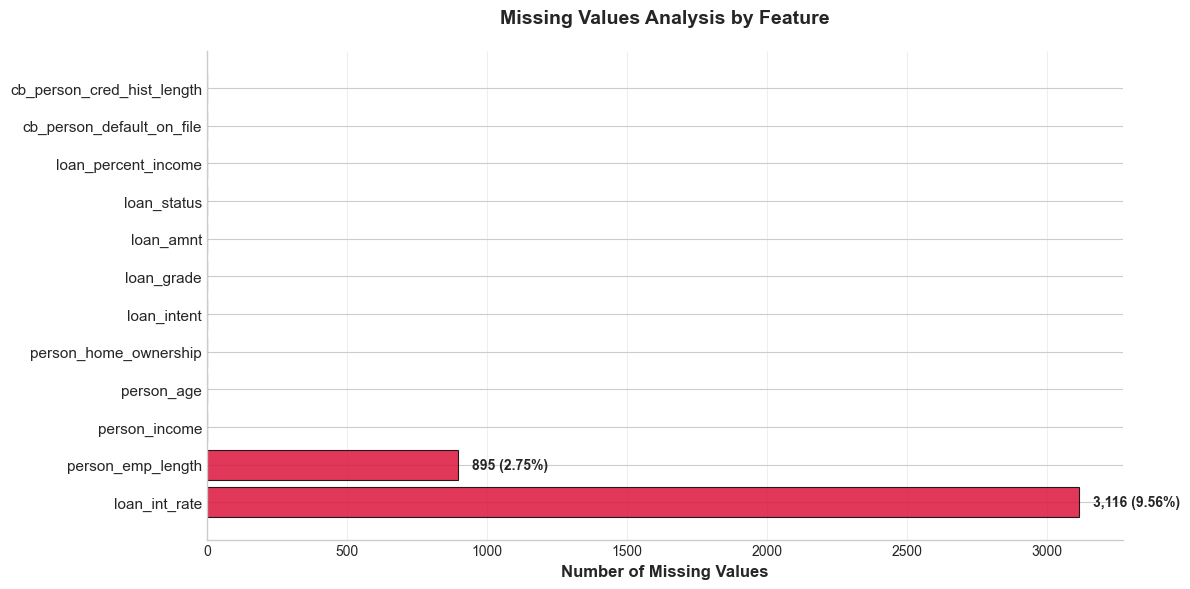


Visualization saved to artifacts/01_eda_images/missing_values.png


In [4]:
# Analyze missing values in the dataset
# Missing values can cause problems in machine learning models, so we need to identify and handle them
missing_counts = credit_data.isna().sum().sort_values(ascending=False)
missing_percentage = (missing_counts / len(credit_data) * 100).round(2)
missing_summary_df = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Percentage': missing_percentage
}).sort_values('Missing_Count', ascending=False)

print('MISSING VALUES ANALYSIS')
features_with_missing = missing_summary_df[missing_summary_df['Missing_Count'] > 0]
if len(features_with_missing) > 0:
    print('Features with missing values:')
    print(features_with_missing)
    print(f'\nTotal features with missing data: {len(features_with_missing)}')
else:
    print('Great! No missing values found in the dataset.')

# Create visualization of missing values
# Red bars = features with missing values, Green bars = complete features
plt.figure(figsize=(12, 6))
bar_colors = ['#DC143C' if count > 0 else '#2E8B57' for count in missing_counts.values]
bars = plt.barh(range(len(missing_counts)), missing_counts.values, 
                color=bar_colors, alpha=0.85, edgecolor='black', linewidth=0.8)
plt.yticks(range(len(missing_counts)), missing_counts.index, fontsize=11)
plt.xlabel('Number of Missing Values', fontsize=12, fontweight='bold')
plt.title('Missing Values Analysis by Feature', fontsize=14, fontweight='bold', pad=20)

# Add text labels showing count and percentage for features with missing values
for i, bar in enumerate(bars):
    width = bar.get_width()
    if width > 0:
        plt.text(width + 50, bar.get_y() + bar.get_height()/2., 
                f'{width:,} ({missing_percentage[i]}%)', 
                ha='left', va='center', fontsize=10, fontweight='bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, '01_eda_images', 'missing_values.png'), dpi=300, bbox_inches='tight')
plt.show()
print('\nVisualization saved to artifacts/01_eda_images/missing_values.png')

In [5]:
# Check for duplicate rows
# Duplicates can indicate data collection issues or need for deduplication
duplicate_count = credit_data.duplicated().sum()
duplicate_percentage = (duplicate_count / len(credit_data) * 100).round(2)

print('DUPLICATE RECORDS CHECK')
print(f'Number of duplicate rows: {duplicate_count:,}')
print(f'Percentage of duplicates: {duplicate_percentage}%')
if duplicate_count > 0:
    print('Note: Duplicates will be handled during preprocessing.')

# Create comprehensive data types summary
# This helps us understand what type of data each column contains
data_types_summary = pd.DataFrame({
    'Column': credit_data.columns,
    'Type': credit_data.dtypes,
    'Non_Null_Count': credit_data.count(),  # Count of non-null values
    'Null_Count': credit_data.isnull().sum()  # Count of null values
})

print('DATA TYPES SUMMARY')
print(data_types_summary)

DUPLICATE RECORDS CHECK
Number of duplicate rows: 165
Percentage of duplicates: 0.51%
Note: Duplicates will be handled during preprocessing.
DATA TYPES SUMMARY
                                                Column     Type  Non_Null_Count  Null_Count
person_age                                  person_age    int64           32581           0
person_income                            person_income    int64           32581           0
person_home_ownership            person_home_ownership   object           32581           0
person_emp_length                    person_emp_length  float64           31686         895
loan_intent                                loan_intent   object           32581           0
loan_grade                                  loan_grade   object           32581           0
loan_amnt                                    loan_amnt    int64           32581           0
loan_int_rate                            loan_int_rate  float64           29465        3116
loan_status 

## 3. Target Variable Analysis

**Purpose**: Understand the distribution of the target variable (loan_status).

**What we analyze**:
- Class distribution (how many good vs bad loans)
- Class imbalance ratio (important for model training)
- Visual representation of the distribution

**Why this matters**: 
- If classes are imbalanced (e.g., 80% good loans, 20% bad loans), we need special techniques during training
- Helps us choose appropriate evaluation metrics
- Guides our model selection strategy

TARGET VARIABLE DISTRIBUTION
Class 0 (Good Loan - No Default): 25,473 (78.18%)
Class 1 (Bad Loan - Default): 7,108 (21.82%)

Class Ratio (Good:Bad): 3.58:1
Imbalance Ratio: 3.58:1

Significant class imbalance detected!
   We will need to use techniques like class weighting or resampling during model training.


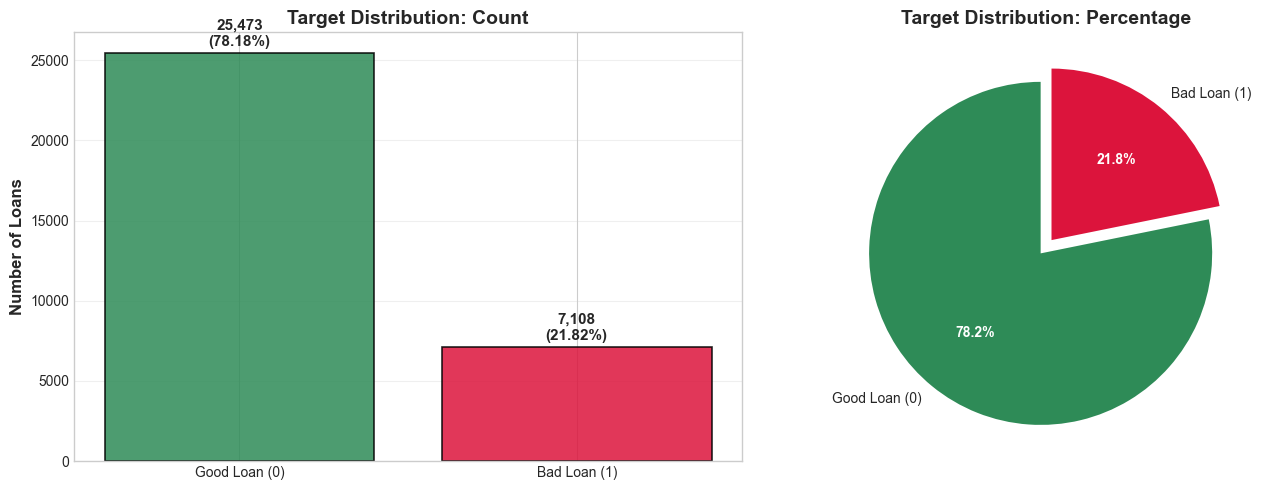


Visualization saved to artifacts/01_eda_images/target_distribution.png


In [6]:
# Analyze the target variable distribution
# This tells us how balanced or imbalanced our dataset is
target_value_counts = credit_data[TARGET_COL].value_counts().sort_index()
target_percentages = (target_value_counts / target_value_counts.sum() * 100).round(2)

print('TARGET VARIABLE DISTRIBUTION')
print(f'Class 0 (Good Loan - No Default): {target_value_counts[0]:,} ({target_percentages[0]}%)')
print(f'Class 1 (Bad Loan - Default): {target_value_counts[1]:,} ({target_percentages[1]}%)')
print(f'\nClass Ratio (Good:Bad): {target_value_counts[0]/target_value_counts[1]:.2f}:1')
imbalance_ratio = max(target_value_counts)/min(target_value_counts)
print(f'Imbalance Ratio: {imbalance_ratio:.2f}:1')

# Interpret imbalance ratio
if imbalance_ratio > 3:
    print('\nSignificant class imbalance detected!')
    print('   We will need to use techniques like class weighting or resampling during model training.')
elif imbalance_ratio > 2:
    print('\nModerate class imbalance detected.')
    print('   Consider using class weighting in model training.')
else:
    print('\nClasses are relatively balanced.')

# Create visualizations: bar chart and pie chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
bar_colors = ['#2E8B57', '#DC143C']  # Green for good loans, Red for bad loans
class_labels = ['Good Loan (0)', 'Bad Loan (1)']

# Bar chart showing counts
bars = axes[0].bar(class_labels, target_value_counts.values, 
                   color=bar_colors, alpha=0.85, edgecolor='black', linewidth=1.2)
axes[0].set_title('Target Distribution: Count', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Loans', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add count and percentage labels on bars
for bar, count, pct in zip(bars, target_value_counts.values, target_percentages.values):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + max(target_value_counts.values)*0.01,
                 f'{count:,}\n({pct}%)', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Pie chart showing percentages
wedges, texts, autotexts = axes[1].pie(target_value_counts.values, labels=class_labels, 
                                       colors=bar_colors, autopct='%1.1f%%', 
                                       startangle=90, explode=(0.05, 0.05))
# Make percentage text white and bold for better visibility
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
axes[1].set_title('Target Distribution: Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, '01_eda_images', 'target_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()
print('\nVisualization saved to artifacts/01_eda_images/target_distribution.png')

## 4. Numeric Features Overview

**Purpose**: Understand the distribution and characteristics of numeric features.

**What we analyze**:
- Summary statistics (mean, median, min, max, percentiles)
- Distribution shapes
- Potential outliers

**Why this matters**: Helps us understand the data range, identify outliers, and decide on appropriate scaling/normalization methods.

In [7]:
# Get numeric features (exclude target variable)
numeric_features = [c for c in numeric_cols if c != TARGET_COL]

# Calculate comprehensive summary statistics
# Percentiles help us understand the distribution: 1st, 5th, 25th (Q1), 50th (median), 75th (Q3), 95th, 99th
summary_stats = credit_data[numeric_features].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]).T

print('SUMMARY STATISTICS FOR NUMERIC FEATURES')
print('Key statistics:')
print('  - count: Number of non-null values')
print('  - mean: Average value')
print('  - std: Standard deviation (spread of data)')
print('  - min/max: Minimum and maximum values')
print('  - percentiles: Values below which X% of data falls')
print('\nDetailed statistics:')
print(summary_stats)

SUMMARY STATISTICS FOR NUMERIC FEATURES
Key statistics:
  - count: Number of non-null values
  - mean: Average value
  - std: Standard deviation (spread of data)
  - min/max: Minimum and maximum values
  - percentiles: Values below which X% of data falls

Detailed statistics:
                              count          mean           std      min        1%        5%       25%       50%       75%        95%        99%         max
person_age                  32581.0     27.734600      6.348078    20.00     21.00     22.00     23.00     26.00     30.00      40.00      50.00      144.00
person_income               32581.0  66074.848470  61983.119168  4000.00  14400.00  22880.00  38500.00  55000.00  79200.00  138000.00  225200.00  6000000.00
person_emp_length           31686.0      4.789686      4.142630     0.00      0.00      0.00      2.00      4.00      7.00      13.00      18.00      123.00
loan_amnt                   32581.0   9589.371106   6322.086646   500.00   1000.00   2000.00   

## 5. Categorical Features Overview

**Purpose**: Understand the distribution of categorical (text) features.

**What we analyze**:
- Value counts for each category
- Most common categories
- Number of unique values per feature

**Why this matters**: Helps us understand which categories are most common and plan encoding strategies (one-hot, label encoding, etc.).

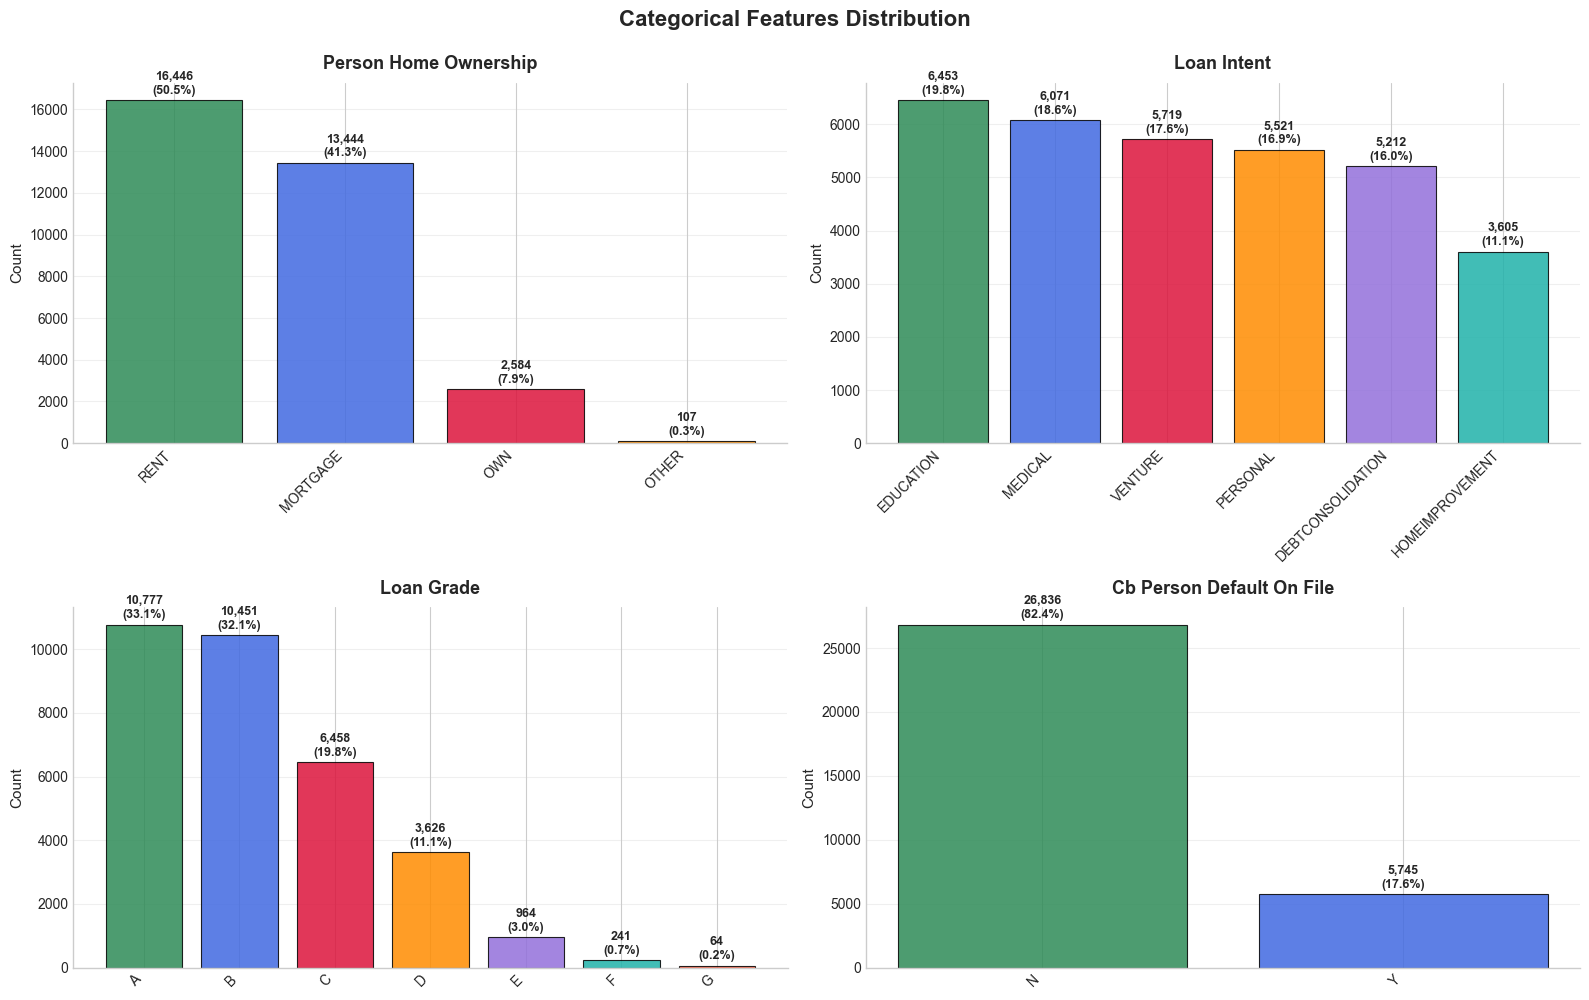


Visualization saved to artifacts/01_eda_images/categorical_distribution.png


In [8]:
# Visualize the distribution of categorical features
# This helps us see which categories are most common and plan our encoding strategy

# Set up subplot grid: arrange categorical features in a 2-column layout
num_categorical = len(categorical_cols)
num_rows = (num_categorical + 1) // 2  # Round up division
fig, axes = plt.subplots(num_rows, 2, figsize=(16, 5*num_rows))
axes = axes.flatten() if num_categorical > 1 else [axes]

# Color palette for different categories
category_colors = ['#2E8B57', '#4169E1', '#DC143C', '#FF8C00', '#9370DB', '#20B2AA', '#FF6347', '#32CD32']

# Create bar chart for each categorical feature
for idx, feature_name in enumerate(categorical_cols):
    # Count occurrences of each category
    category_counts = credit_data[feature_name].value_counts()
    category_percentages = (category_counts.values / category_counts.sum() * 100).round(1)
    
    # Create bar chart
    bars = axes[idx].bar(range(len(category_counts)), category_counts.values, 
                        color=category_colors[:len(category_counts)], 
                        alpha=0.85, edgecolor='black', linewidth=0.8)
    
    # Formatting
    axes[idx].set_title(f'{feature_name.replace("_", " ").title()}', 
                       fontsize=13, fontweight='bold', pad=10)
    axes[idx].set_ylabel('Count', fontsize=11)
    axes[idx].set_xticks(range(len(category_counts)))
    axes[idx].set_xticklabels(category_counts.index, rotation=45, ha='right', fontsize=10)
    
    # Add count and percentage labels on each bar
    for i, (bar, count, pct) in enumerate(zip(bars, category_counts.values, category_percentages)):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height + max(category_counts.values)*0.01,
                      f'{count:,}\n({pct}%)', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)
    axes[idx].grid(axis='y', alpha=0.3)

# Hide unused subplots
for idx in range(len(categorical_cols), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Categorical Features Distribution', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, '01_eda_images', 'categorical_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()
print('\nVisualization saved to artifacts/01_eda_images/categorical_distribution.png')

## 6. Outlier Detection & Analysis

**Purpose**: Identify extreme values that might be errors or need special handling.

**Methods used**:
- **IQR Method**: Identifies values outside Q1 - 1.5×IQR and Q3 + 1.5×IQR
- **Z-Score Method**: Identifies values beyond 3 standard deviations from the mean

**Why this matters**: Outliers can skew model training and predictions. We need to decide whether to cap, remove, or keep them based on domain knowledge.

In [9]:
# Detect outliers using two different methods for comparison
# Method 1: IQR (Interquartile Range) - robust to outliers, uses quartiles
# Method 2: Z-Score - uses mean and standard deviation, sensitive to outliers

outlier_summary_list = []
for feature_name in numeric_features:
    # IQR Method: Calculate quartiles and interquartile range
    Q1 = credit_data[feature_name].quantile(0.25)  # 25th percentile (first quartile)
    Q3 = credit_data[feature_name].quantile(0.75)  # 75th percentile (third quartile)
    IQR = Q3 - Q1  # Interquartile range (middle 50% of data)
    
    # Define outlier boundaries: values outside Q1 - 1.5×IQR or Q3 + 1.5×IQR are outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_iqr_count = ((credit_data[feature_name] < lower_bound) | 
                          (credit_data[feature_name] > upper_bound)).sum()
    
    # Z-Score Method: Calculate how many standard deviations each value is from the mean
    # Values beyond 3 standard deviations are considered outliers
    feature_data_no_nulls = credit_data[feature_name].dropna()
    z_scores = np.abs(stats.zscore(feature_data_no_nulls))
    outliers_zscore_count = (z_scores > 3).sum()
    
    # Store results for this feature
    outlier_summary_list.append({
        'Feature': feature_name,
        'IQR_Outliers': outliers_iqr_count,
        'IQR_Percentage': (outliers_iqr_count / len(credit_data) * 100).round(2),
        'ZScore_Outliers': outliers_zscore_count,
        'ZScore_Percentage': (outliers_zscore_count / len(feature_data_no_nulls) * 100).round(2) 
                             if len(feature_data_no_nulls) > 0 else 0
    })

outlier_summary_df = pd.DataFrame(outlier_summary_list)

print('OUTLIER DETECTION SUMMARY')
print('Two methods compared:')
print('  - IQR Method: Uses quartiles (more robust, less sensitive to extreme values)')
print('  - Z-Score Method: Uses mean/std (more sensitive, flags extreme deviations)')
print('\nResults:')
print(outlier_summary_df)

OUTLIER DETECTION SUMMARY
Two methods compared:
  - IQR Method: Uses quartiles (more robust, less sensitive to extreme values)
  - Z-Score Method: Uses mean/std (more sensitive, flags extreme deviations)

Results:
                      Feature  IQR_Outliers  IQR_Percentage  ZScore_Outliers  ZScore_Percentage
0                  person_age          1494            4.59              558               1.71
1               person_income          1484            4.55              233               0.72
2           person_emp_length           853            2.62              321               1.01
3                   loan_amnt          1689            5.18              337               1.03
4               loan_int_rate             6            0.02               38               0.13
5         loan_percent_income           651            2.00              336               1.03
6  cb_person_cred_hist_length          1142            3.51              284               0.87


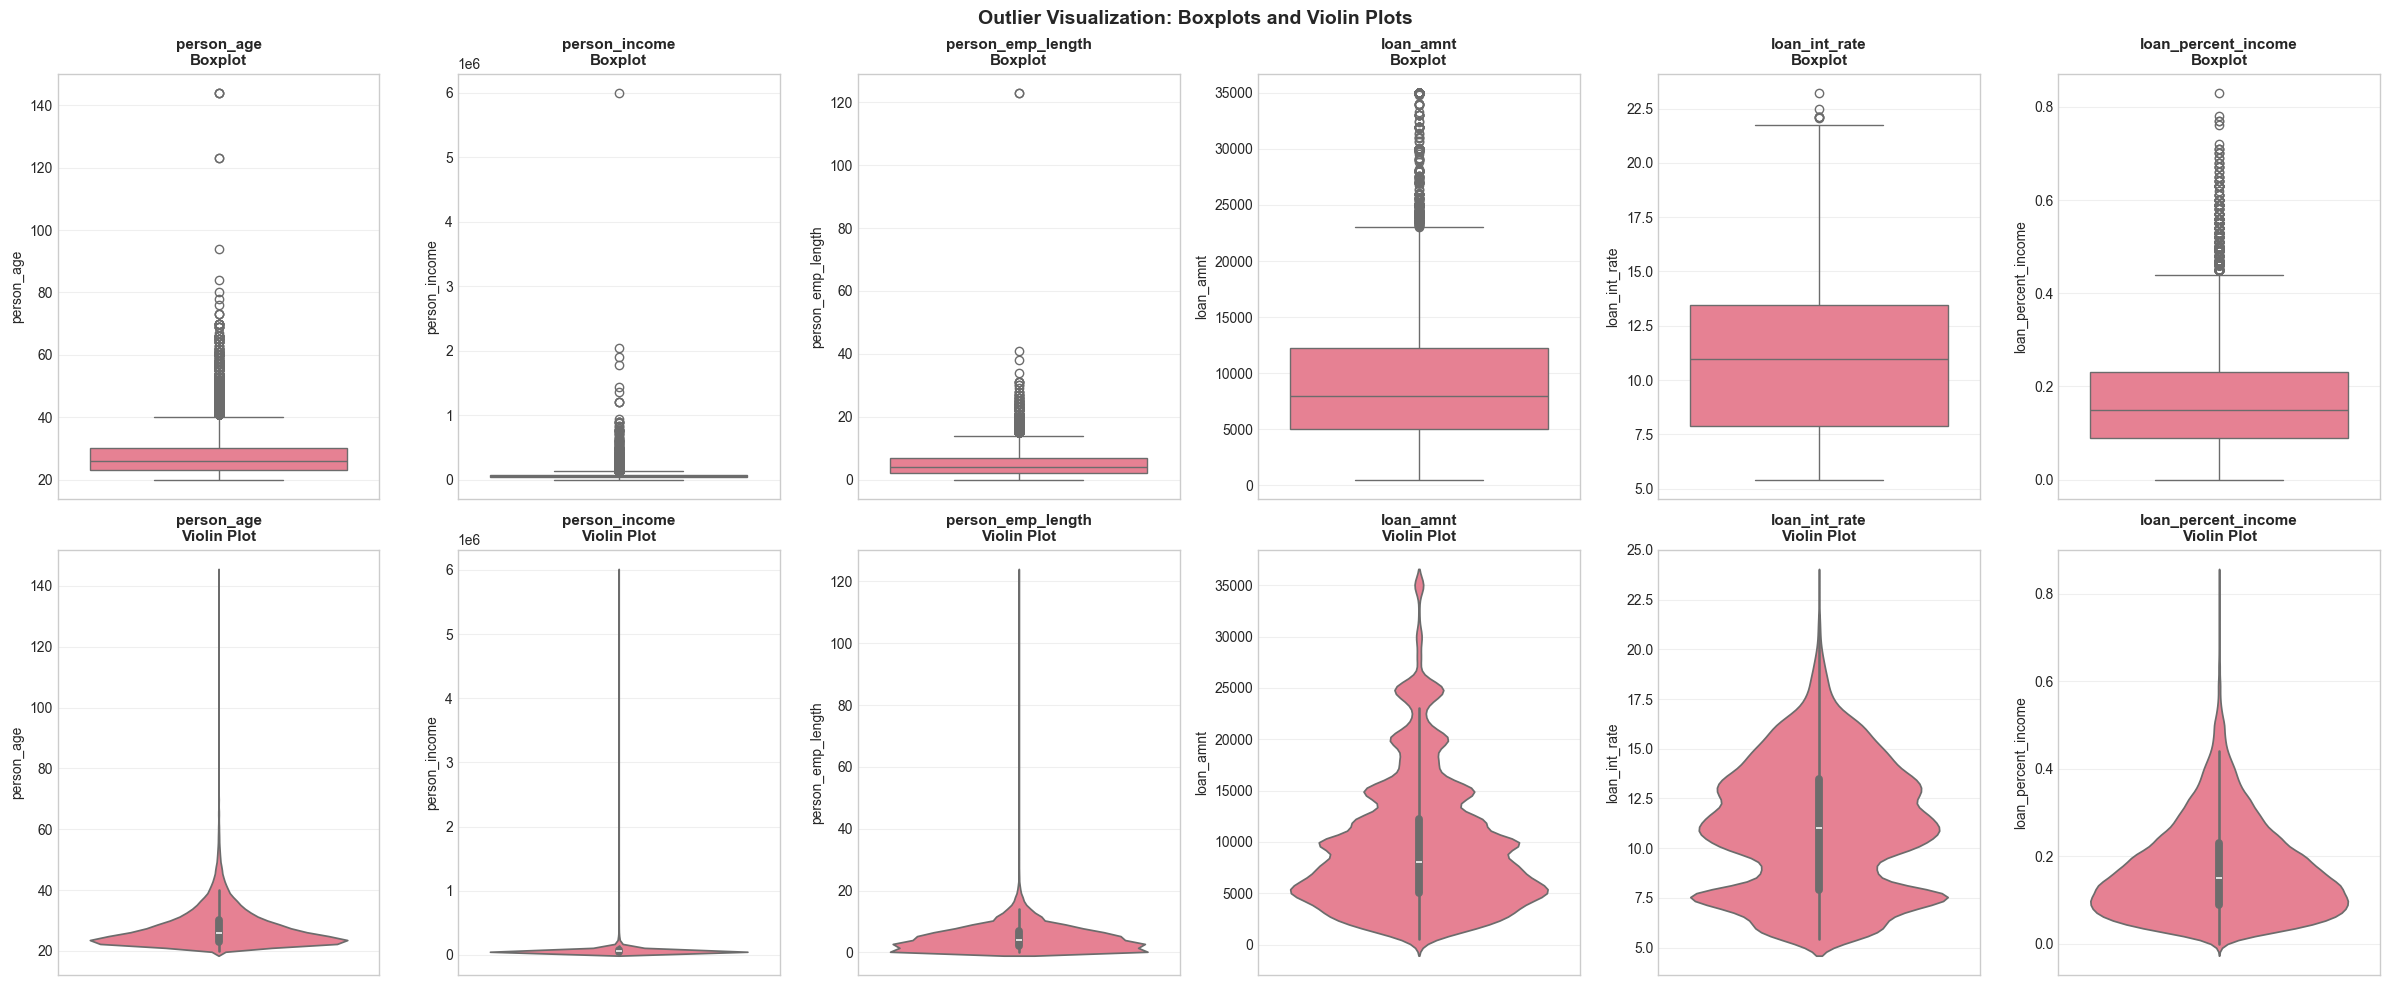

In [10]:
plot_cols = numeric_features[:6]
n_cols = len(plot_cols)
fig, axes = plt.subplots(2, n_cols, figsize=(4*n_cols, 10))

for idx, col in enumerate(plot_cols):
    # Boxplot
    sns.boxplot(data=credit_data, y=col, ax=axes[0, idx])
    axes[0, idx].set_title(f'{col}\nBoxplot', fontsize=11, fontweight='bold')
    axes[0, idx].grid(axis='y', alpha=0.3)
    
    # Violin plot
    sns.violinplot(data=credit_data, y=col, ax=axes[1, idx])
    axes[1, idx].set_title(f'{col}\nViolin Plot', fontsize=11, fontweight='bold')
    axes[1, idx].grid(axis='y', alpha=0.3)

plt.suptitle('Outlier Visualization: Boxplots and Violin Plots', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, '01_eda_images', 'outlier_visualization.png'), dpi=300, bbox_inches='tight')
plt.show()


## 7. Univariate Analysis - Numeric Features

Skewness and Kurtosis Analysis:
                             Skewness     Kurtosis
person_income               32.865349  2693.272776
person_emp_length            2.614455    43.722338
person_age                   2.581393    18.560825
cb_person_cred_hist_length   1.661790     3.716194
loan_amnt                    1.192477     1.423565
loan_percent_income          1.064669     1.223687
loan_int_rate                0.208550    -0.671609


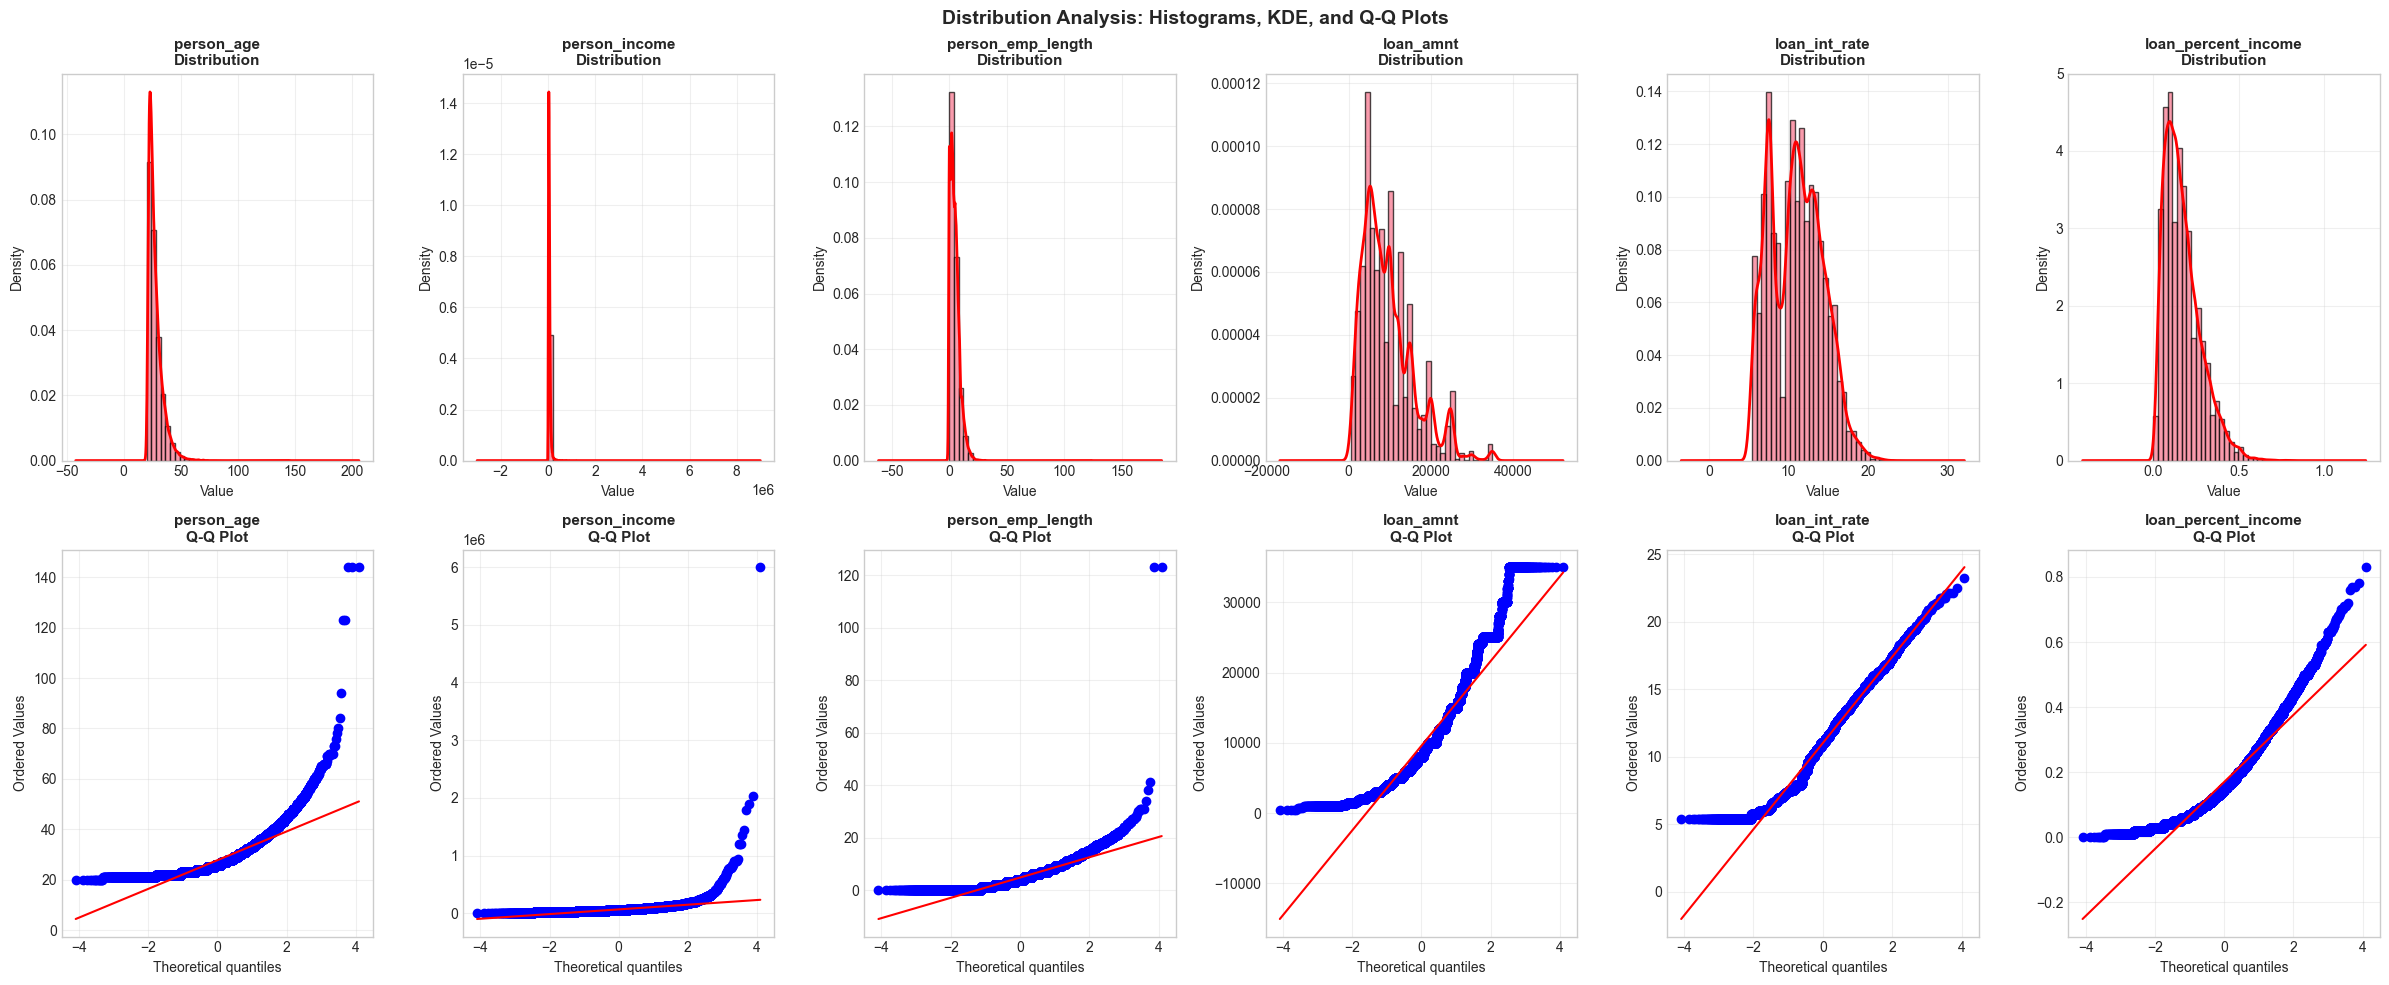

In [11]:
skew_kurt = pd.DataFrame({
    'Skewness': credit_data[numeric_features].skew(numeric_only=True),
    'Kurtosis': credit_data[numeric_features].kurtosis(numeric_only=True)
}).sort_values('Skewness', key=lambda s: s.abs(), ascending=False)

print('Skewness and Kurtosis Analysis:')
print(skew_kurt)

plot_cols = numeric_features[:6]
n_cols = len(plot_cols)
fig, axes = plt.subplots(2, n_cols, figsize=(4*n_cols, 10))

for idx, col in enumerate(plot_cols):
    # Histogram with KDE
    data = credit_data[col].dropna()
    axes[0, idx].hist(data, bins=30, alpha=0.7, edgecolor='black', density=True)
    data.plot(kind='kde', ax=axes[0, idx], color='red', linewidth=2)
    axes[0, idx].set_title(f'{col}\nDistribution', fontsize=11, fontweight='bold')
    axes[0, idx].set_xlabel('Value')
    axes[0, idx].set_ylabel('Density')
    axes[0, idx].grid(alpha=0.3)
    
    # Q-Q plot for normality
    stats.probplot(credit_data[col].dropna(), dist="norm", plot=axes[1, idx])
    axes[1, idx].set_title(f'{col}\nQ-Q Plot', fontsize=11, fontweight='bold')
    axes[1, idx].grid(alpha=0.3)

plt.suptitle('Distribution Analysis: Histograms, KDE, and Q-Q Plots', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, '01_eda_images', 'univariate_numeric.png'), dpi=300, bbox_inches='tight')
plt.show()


## 8. Univariate Analysis - Categorical Features


In [12]:
for col in categorical_cols:
    print(f'\n{col}:')
    print(credit_data[col].value_counts())
    print(f'Unique values: {credit_data[col].nunique()}')
    print(f'Mode: {credit_data[col].mode()[0]} ({credit_data[col].value_counts().iloc[0]} occurrences)')



person_home_ownership:
person_home_ownership
RENT        16446
MORTGAGE    13444
OWN          2584
OTHER         107
Name: count, dtype: int64
Unique values: 4
Mode: RENT (16446 occurrences)

loan_intent:
loan_intent
EDUCATION            6453
MEDICAL              6071
VENTURE              5719
PERSONAL             5521
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: count, dtype: int64
Unique values: 6
Mode: EDUCATION (6453 occurrences)

loan_grade:
loan_grade
A    10777
B    10451
C     6458
D     3626
E      964
F      241
G       64
Name: count, dtype: int64
Unique values: 7
Mode: A (10777 occurrences)

cb_person_default_on_file:
cb_person_default_on_file
N    26836
Y     5745
Name: count, dtype: int64
Unique values: 2
Mode: N (26836 occurrences)


## 9. Bivariate Analysis - Features vs Target


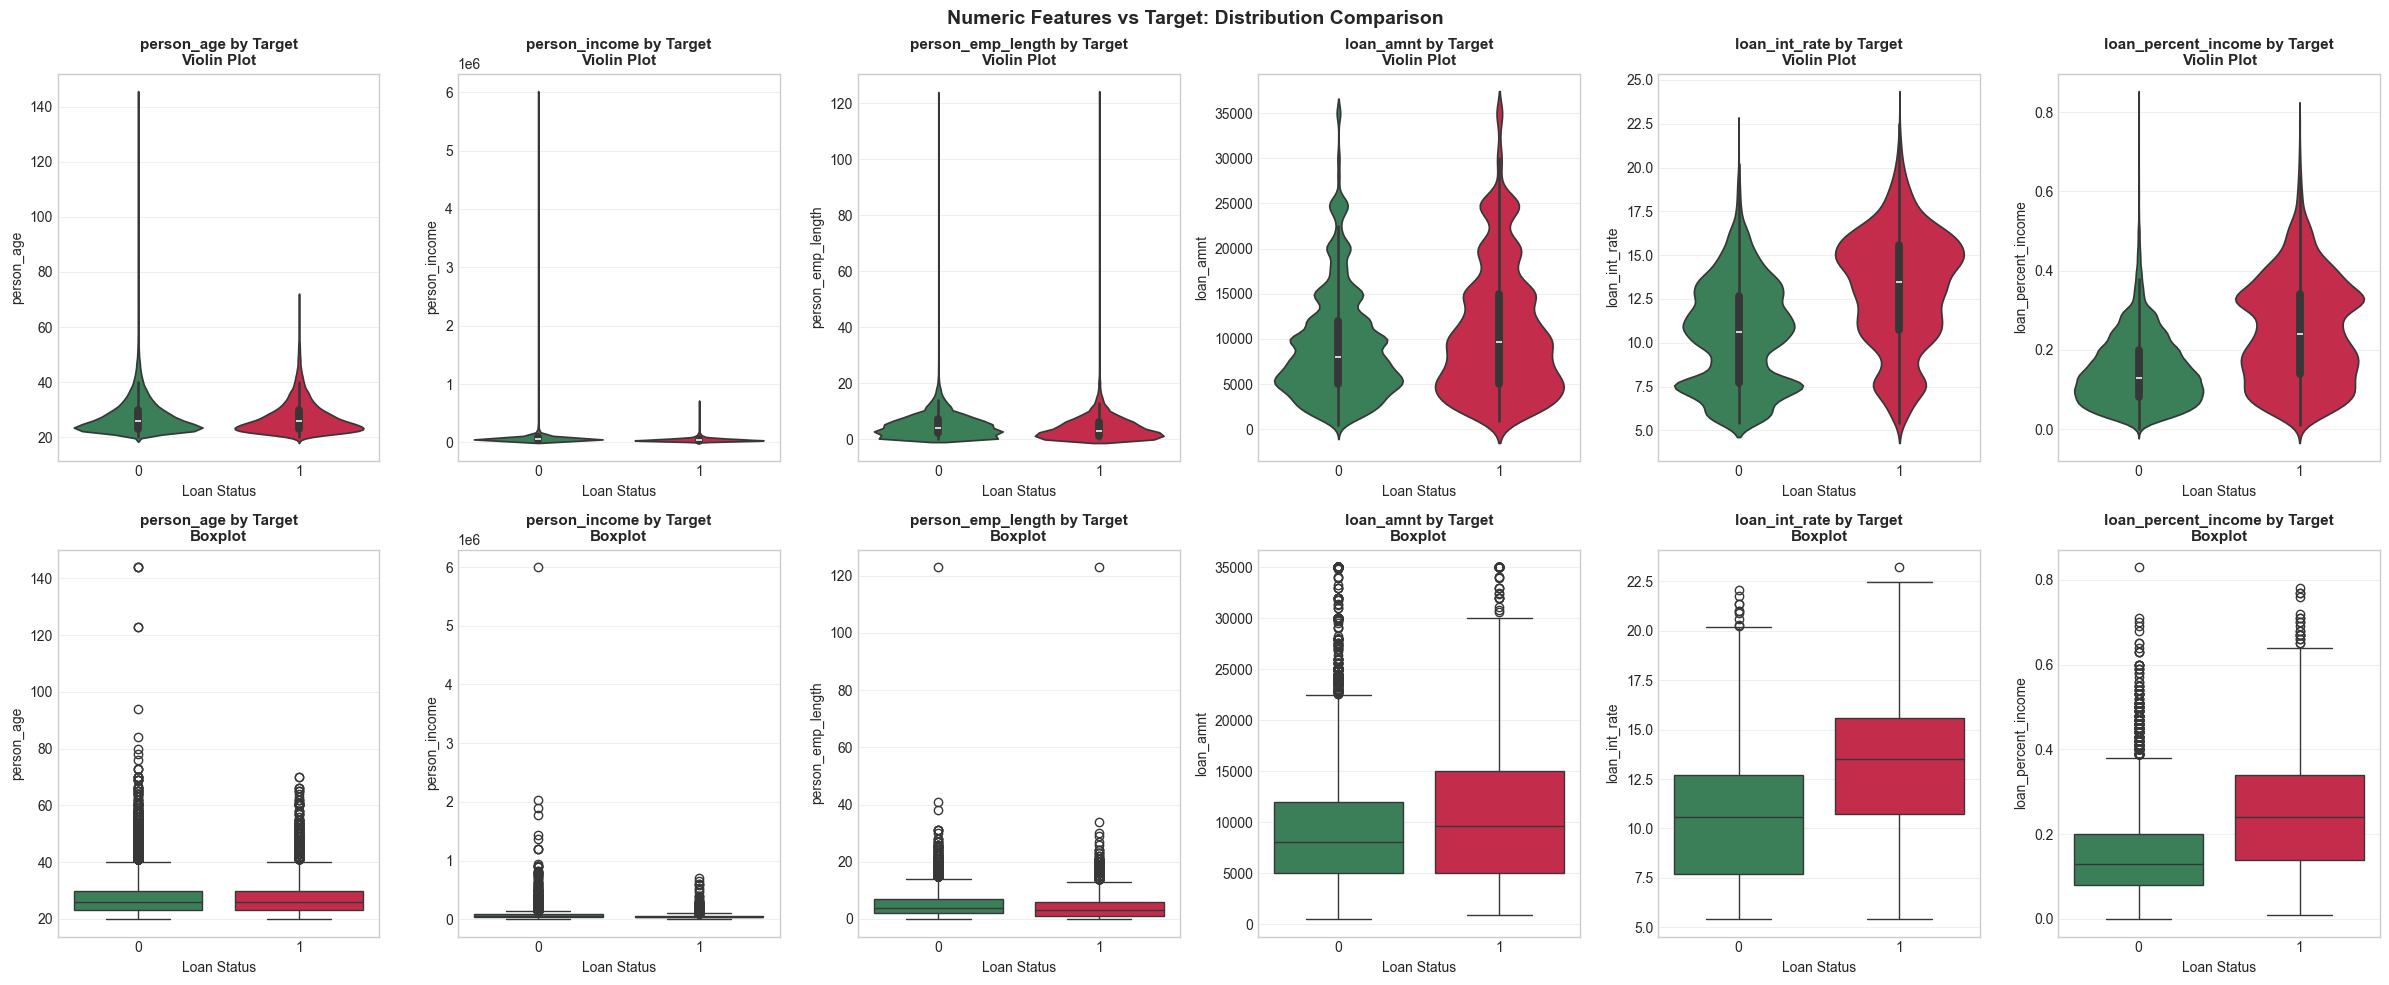

In [13]:
plot_cols = numeric_features[:6]
n_cols = len(plot_cols)
fig, axes = plt.subplots(2, n_cols, figsize=(4*n_cols, 10))

for idx, col in enumerate(plot_cols):
    # Violin plot by target
    sns.violinplot(data=credit_data, x=TARGET_COL, y=col, ax=axes[0, idx], palette=['#2E8B57', '#DC143C'])
    axes[0, idx].set_title(f'{col} by Target\nViolin Plot', fontsize=11, fontweight='bold')
    axes[0, idx].set_xlabel('Loan Status')
    axes[0, idx].set_ylabel(col)
    axes[0, idx].grid(axis='y', alpha=0.3)
    
    # Boxplot by target
    sns.boxplot(data=credit_data, x=TARGET_COL, y=col, ax=axes[1, idx], palette=['#2E8B57', '#DC143C'])
    axes[1, idx].set_title(f'{col} by Target\nBoxplot', fontsize=11, fontweight='bold')
    axes[1, idx].set_xlabel('Loan Status')
    axes[1, idx].set_ylabel(col)
    axes[1, idx].grid(axis='y', alpha=0.3)

plt.suptitle('Numeric Features vs Target: Distribution Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, '01_eda_images', 'bivariate_numeric_target.png'), dpi=300, bbox_inches='tight')
plt.show()


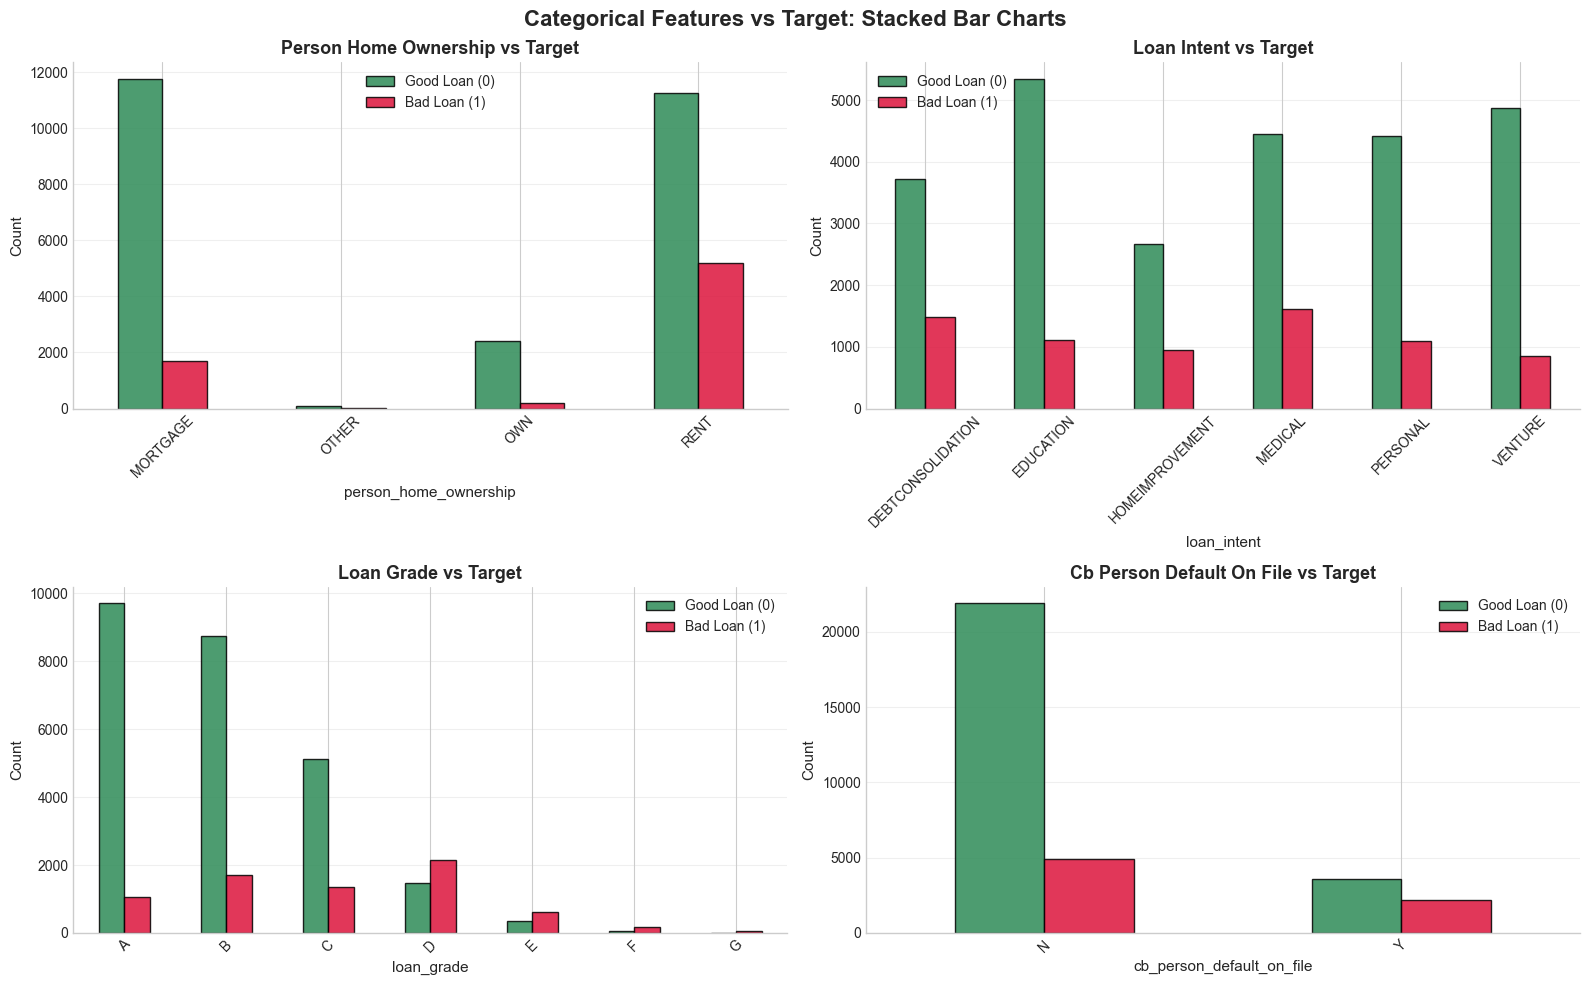

In [14]:
n_cols = len(categorical_cols)
n_rows = (n_cols + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(16, 5*n_rows))
axes = axes.flatten() if n_cols > 1 else [axes]

for idx, col in enumerate(categorical_cols):
    crosstab = pd.crosstab(credit_data[col], credit_data[TARGET_COL], normalize='index') * 100
    crosstab_counts = pd.crosstab(credit_data[col], credit_data[TARGET_COL])
    
    crosstab_counts.plot(kind='bar', ax=axes[idx], color=['#2E8B57', '#DC143C'], alpha=0.85, edgecolor='black')
    axes[idx].set_title(f'{col.replace("_", " ").title()} vs Target', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=11)
    axes[idx].set_ylabel('Count', fontsize=11)
    axes[idx].legend(['Good Loan (0)', 'Bad Loan (1)'], fontsize=10)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)

for idx in range(len(categorical_cols), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Categorical Features vs Target: Stacked Bar Charts', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, '01_eda_images', 'bivariate_categorical_target.png'), dpi=300, bbox_inches='tight')
plt.show()


## 10. Correlation Analysis


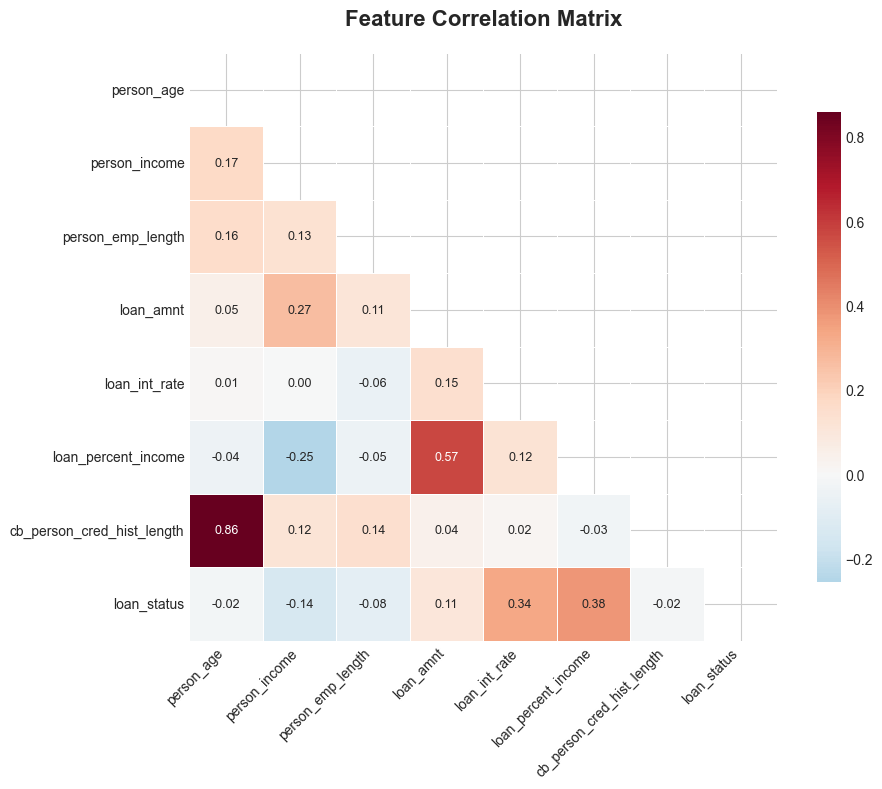


Top Features Correlated with Target:
loan_percent_income           0.379366
loan_int_rate                 0.335133
person_income                 0.144449
loan_amnt                     0.105376
person_emp_length             0.082489
person_age                    0.021629
cb_person_cred_hist_length    0.015529
Name: loan_status, dtype: float64


In [15]:
corr_features = numeric_features + [TARGET_COL]
corr_matrix = credit_data[corr_features].corr()

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, annot_kws={'size': 9})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, '01_eda_images', 'correlation_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

target_corr = corr_matrix[TARGET_COL].drop(TARGET_COL).abs().sort_values(ascending=False)
print('\nTop Features Correlated with Target:')
print(target_corr.head(10))


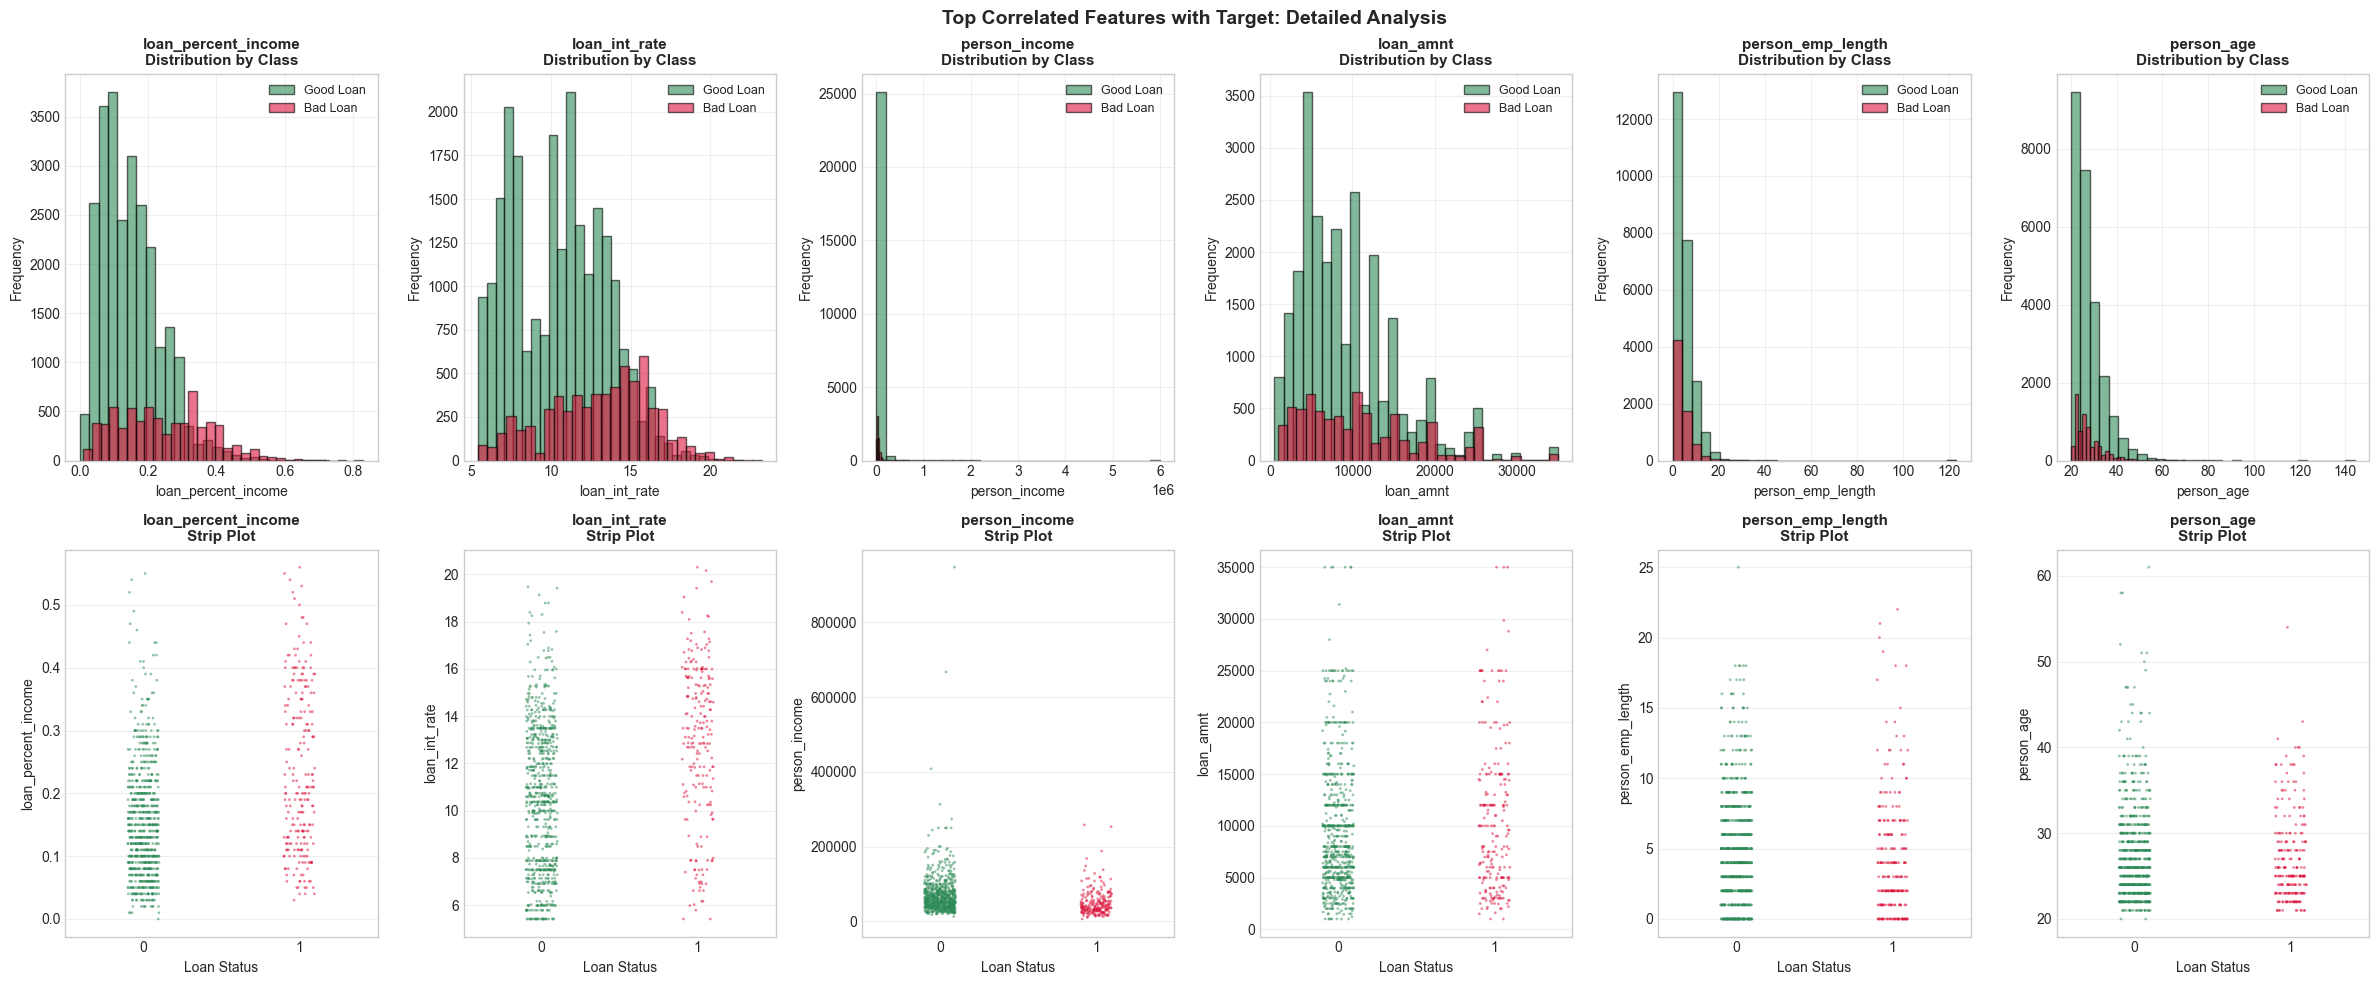

In [16]:
top_corr_cols = target_corr.head(6).index.tolist()
n_cols = len(top_corr_cols)
fig, axes = plt.subplots(2, n_cols, figsize=(4*n_cols, 10))

for idx, col in enumerate(top_corr_cols):
    # KDE plot
    for target_val in [0, 1]:
        subset = credit_data[credit_data[TARGET_COL] == target_val][col].dropna()
        axes[0, idx].hist(subset, bins=30, alpha=0.6, label=f'Class {target_val}', 
                         color=['#2E8B57', '#DC143C'][target_val], edgecolor='black')
    axes[0, idx].set_title(f'{col}\nDistribution by Class', fontsize=11, fontweight='bold')
    axes[0, idx].set_xlabel(col)
    axes[0, idx].set_ylabel('Frequency')
    axes[0, idx].legend(['Good Loan', 'Bad Loan'], fontsize=9)
    axes[0, idx].grid(alpha=0.3)
    
    # Strip plot
    sample_df = credit_data[[col, TARGET_COL]].dropna().sample(min(1000, len(credit_data)), random_state=42)
    sns.stripplot(data=sample_df, x=TARGET_COL, y=col, ax=axes[1, idx], 
                  palette=['#2E8B57', '#DC143C'], alpha=0.5, size=2)
    axes[1, idx].set_title(f'{col}\nStrip Plot', fontsize=11, fontweight='bold')
    axes[1, idx].set_xlabel('Loan Status')
    axes[1, idx].set_ylabel(col)
    axes[1, idx].grid(axis='y', alpha=0.3)

plt.suptitle('Top Correlated Features with Target: Detailed Analysis', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, '01_eda_images', 'top_correlated_features.png'), dpi=300, bbox_inches='tight')
plt.show()


## 11. Statistical Tests

**Purpose**: Determine if features are statistically significantly related to the target variable.

**Tests performed**:
- **Chi-Square Test**: For categorical features vs target (tests independence)
- **T-Test**: For numeric features vs target (assumes normal distribution)
- **Mann-Whitney U Test**: For numeric features vs target (non-parametric, no distribution assumption)
- **Normality Test**: Check if data follows normal distribution

**Why this matters**: Statistically significant features are more likely to be useful predictors. Non-significant features might be noise.


In [17]:
# Chi-Square Test for Categorical Features
# Purpose: Test if categorical features are independent of the target variable
# Null hypothesis: Feature and target are independent (not related)
# If p-value < 0.05, we reject null hypothesis (feature IS related to target)

chi2_test_results = []
for categorical_feature in categorical_cols:
    # Create contingency table: cross-tabulation of feature categories vs target classes
    contingency_table = pd.crosstab(credit_data[categorical_feature], credit_data[TARGET_COL])
    
    # Perform chi-square test
    chi2_statistic, p_value, degrees_of_freedom, expected_frequencies = chi2_contingency(contingency_table)
    
    # Store results
    chi2_test_results.append({
        'Feature': categorical_feature,
        'Chi2_Statistic': chi2_statistic,  # Larger values = stronger relationship
        'P_Value': p_value,  # Probability that relationship is due to chance
        'Significant': 'Yes' if p_value < 0.05 else 'No'  # p < 0.05 = statistically significant
    })

chi2_results_df = pd.DataFrame(chi2_test_results)

print('CHI-SQUARE TEST RESULTS (Categorical Features vs Target)')
print('Interpretation:')
print('  - P_Value < 0.05: Feature is significantly related to target (reject independence)')
print('  - P_Value >= 0.05: No significant relationship found')
print('\nResults:')
print(chi2_results_df)


CHI-SQUARE TEST RESULTS (Categorical Features vs Target)
Interpretation:
  - P_Value < 0.05: Feature is significantly related to target (reject independence)
  - P_Value >= 0.05: No significant relationship found

Results:
                     Feature  Chi2_Statistic        P_Value Significant
0      person_home_ownership     1907.980698   0.000000e+00         Yes
1                loan_intent      520.511561  2.980682e-110         Yes
2                 loan_grade     5609.184187   0.000000e+00         Yes
3  cb_person_default_on_file     1044.439595  3.934660e-229         Yes


In [18]:
# Statistical Tests for Numeric Features
# Purpose: Test if numeric features have significantly different distributions between target classes
# We use two tests: T-test (parametric, assumes normality) and Mann-Whitney U (non-parametric, no assumptions)

statistical_test_results = []
for numeric_feature in numeric_features:
    # Split data into two groups: good loans (0) and bad loans (1)
    good_loans_group = credit_data[credit_data[TARGET_COL] == 0][numeric_feature].dropna()
    bad_loans_group = credit_data[credit_data[TARGET_COL] == 1][numeric_feature].dropna()
    
    # T-Test: Compares means of two groups (assumes normal distribution)
    # Null hypothesis: Means are equal (no difference between groups)
    t_statistic, t_pvalue = ttest_ind(good_loans_group, bad_loans_group)
    
    # Mann-Whitney U Test: Non-parametric alternative (doesn't assume normal distribution)
    # Tests if distributions are different (more robust to outliers)
    u_statistic, u_pvalue = mannwhitneyu(good_loans_group, bad_loans_group, alternative='two-sided')
    
    # Normality Test: Check if data follows normal distribution
    # Needed to decide which test is more appropriate
    _, normality_pvalue_good = normaltest(good_loans_group)
    _, normality_pvalue_bad = normaltest(bad_loans_group)
    
    # Store results
    statistical_test_results.append({
        'Feature': numeric_feature,
        'T_Statistic': t_statistic,
        'T_PValue': t_pvalue,
        'T_Significant': 'Yes' if t_pvalue < 0.05 else 'No',
        'U_Statistic': u_statistic,
        'U_PValue': u_pvalue,
        'U_Significant': 'Yes' if u_pvalue < 0.05 else 'No',
        'Normality_Class0': 'Yes' if normality_pvalue_good > 0.05 else 'No',  # p > 0.05 = normal
        'Normality_Class1': 'Yes' if normality_pvalue_bad > 0.05 else 'No'
    })

statistical_tests_df = pd.DataFrame(statistical_test_results)

print('STATISTICAL TEST RESULTS (Numeric Features vs Target)')
print('Tests performed:')
print('  - T-Test: Compares means (assumes normal distribution)')
print('  - Mann-Whitney U: Compares distributions (no assumptions, more robust)')
print('  - Normality Test: Checks if data is normally distributed')
print('\nInterpretation:')
print('  - P_Value < 0.05: Feature distributions differ significantly between classes')
print('  - Use Mann-Whitney U if data is not normal (more reliable)')
print('\nResults:')
print(statistical_tests_df[['Feature', 'T_PValue', 'T_Significant', 'U_PValue', 'U_Significant']])


STATISTICAL TEST RESULTS (Numeric Features vs Target)
Tests performed:
  - T-Test: Compares means (assumes normal distribution)
  - Mann-Whitney U: Compares distributions (no assumptions, more robust)
  - Normality Test: Checks if data is normally distributed

Interpretation:
  - P_Value < 0.05: Feature distributions differ significantly between classes
  - Use Mann-Whitney U if data is not normal (more reliable)

Results:
                      Feature       T_PValue T_Significant      U_PValue U_Significant
0                  person_age   9.443967e-05           Yes  1.740007e-09           Yes
1               person_income  2.044208e-151           Yes  0.000000e+00           Yes
2           person_emp_length   5.735240e-49           Yes  1.501798e-67           Yes
3                   loan_amnt   4.239733e-81           Yes  5.792273e-52           Yes
4               loan_int_rate   0.000000e+00           Yes  0.000000e+00           Yes
5         loan_percent_income   0.000000e+00       

## 12. Feature Interactions


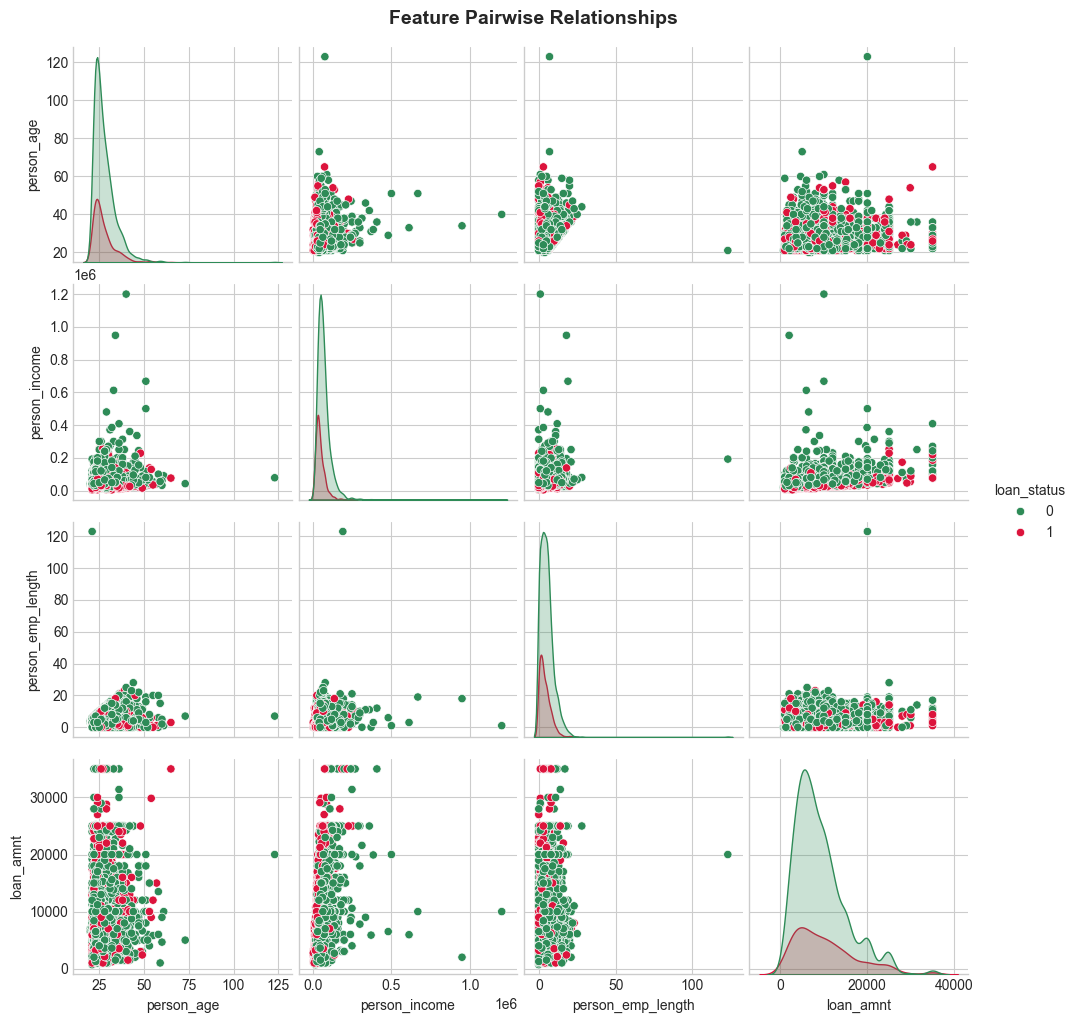

In [19]:
sample_n = min(3000, len(credit_data))
pair_cols = numeric_features[:4] + [TARGET_COL]
pairplot_df = credit_data[pair_cols].sample(sample_n, random_state=42)

sns.pairplot(pairplot_df, hue=TARGET_COL, palette=['#2E8B57', '#DC143C'], diag_kind='kde')
plt.suptitle('Feature Pairwise Relationships', fontsize=14, fontweight='bold', y=1.02)
plt.savefig(os.path.join(ARTIFACTS_DIR, '01_eda_images', 'pairplot.png'), dpi=300, bbox_inches='tight')
plt.show()


Number of components for 95% variance: 6/7


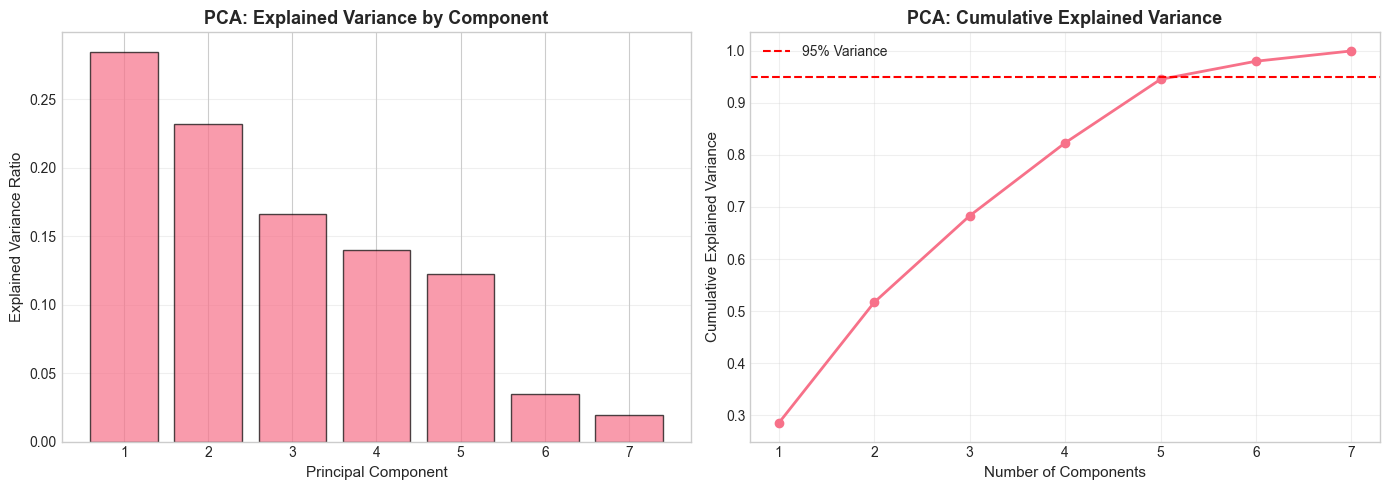

In [20]:
# PCA preview for dimensionality reduction insight
numeric_data = credit_data[numeric_features].fillna(credit_data[numeric_features].median())
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(numeric_data)

pca = PCA()
pca.fit(numeric_scaled)

explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(1, len(explained_var) + 1), explained_var, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Principal Component', fontsize=11)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=11)
axes[0].set_title('PCA: Explained Variance by Component', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

axes[1].plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o', linewidth=2, markersize=6)
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
axes[1].set_xlabel('Number of Components', fontsize=11)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=11)
axes[1].set_title('PCA: Cumulative Explained Variance', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

n_components_95 = np.where(cumulative_var >= 0.95)[0][0] + 1
print(f'Number of components for 95% variance: {n_components_95}/{len(numeric_features)}')

plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, '01_eda_images', 'pca_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()


## 13. Distribution Comparisons


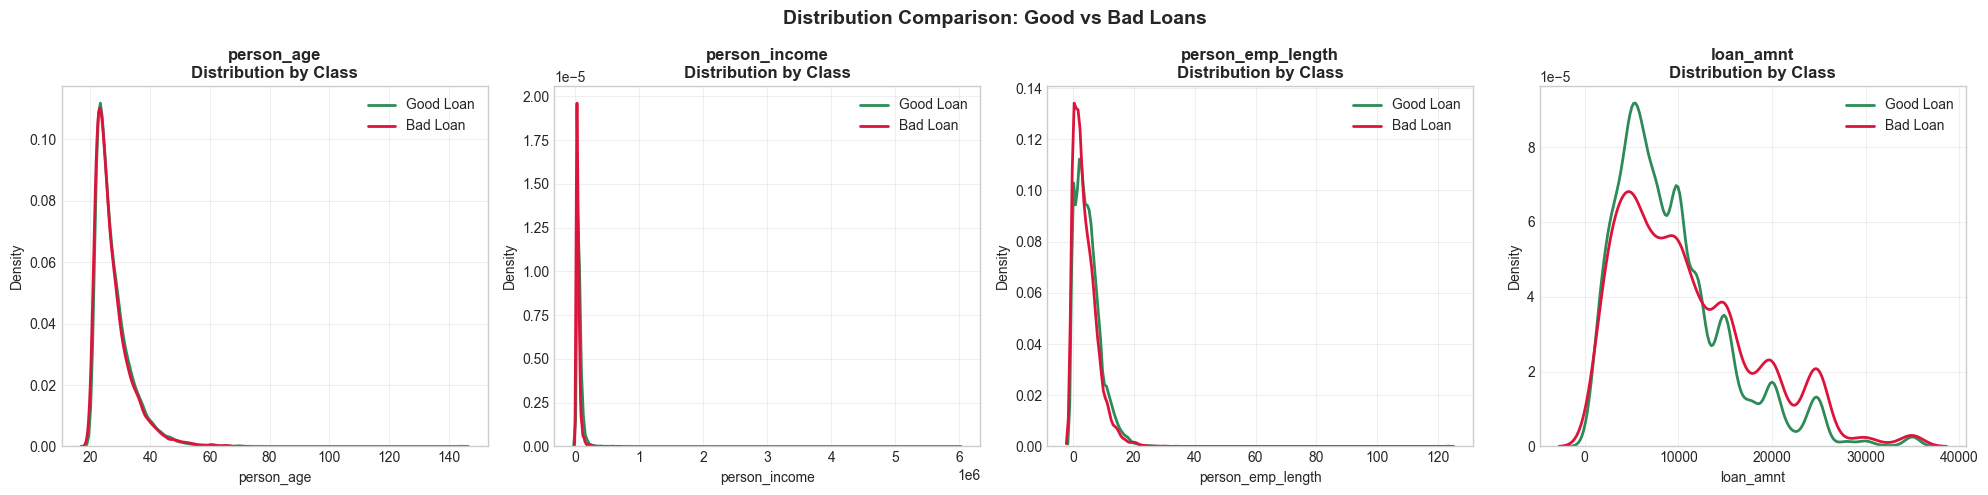

In [21]:
plot_cols = numeric_features[:4]
n_cols = len(plot_cols)
fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 5))

for idx, col in enumerate(plot_cols):
    for target_val in [0, 1]:
        subset = credit_data[credit_data[TARGET_COL] == target_val][col].dropna()
        sns.kdeplot(data=subset, ax=axes[idx], label=f'Class {target_val}', 
                   color=['#2E8B57', '#DC143C'][target_val], linewidth=2)
    axes[idx].set_title(f'{col}\nDistribution by Class', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Density')
    axes[idx].legend(['Good Loan', 'Bad Loan'], fontsize=10)
    axes[idx].grid(alpha=0.3)

plt.suptitle('Distribution Comparison: Good vs Bad Loans', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, '01_eda_images', 'distribution_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()


## 14. Feature Importance Ranking


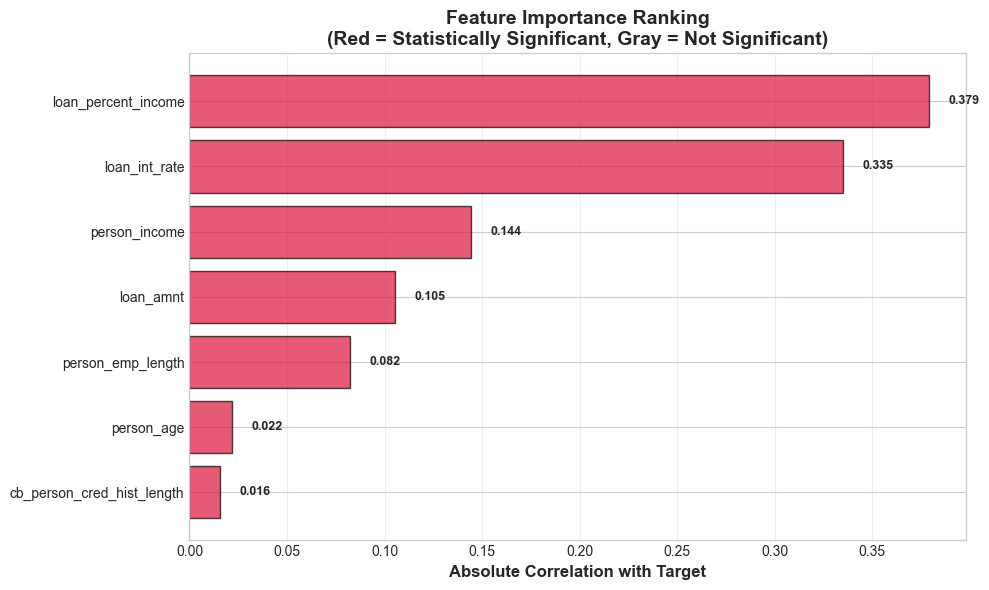


Top 10 Most Important Features:
                      Feature  Correlation_Abs  Statistical_PValue  Statistical_Significant
5         loan_percent_income         0.379366        0.000000e+00                     True
4               loan_int_rate         0.335133        0.000000e+00                     True
1               person_income         0.144449        0.000000e+00                     True
3                   loan_amnt         0.105376        5.792273e-52                     True
2           person_emp_length         0.082489        1.501798e-67                     True
0                  person_age         0.021629        1.740007e-09                     True
6  cb_person_cred_hist_length         0.015529        1.769935e-05                     True


In [22]:
# Combine correlation and statistical significance
feature_importance = pd.DataFrame({
    'Feature': numeric_features,
    'Correlation_Abs': [target_corr.get(f, 0) for f in numeric_features]
})

stat_sig = statistical_tests_df.set_index('Feature')['U_PValue']
feature_importance['Statistical_PValue'] = [stat_sig.get(f, 1.0) for f in feature_importance['Feature']]
feature_importance['Statistical_Significant'] = feature_importance['Statistical_PValue'] < 0.05

feature_importance = feature_importance.sort_values('Correlation_Abs', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#DC143C' if sig else '#808080' for sig in feature_importance['Statistical_Significant']]
bars = ax.barh(feature_importance['Feature'], feature_importance['Correlation_Abs'], color=colors, alpha=0.7, edgecolor='black')
ax.set_xlabel('Absolute Correlation with Target', fontsize=12, fontweight='bold')
ax.set_title('Feature Importance Ranking\n(Red = Statistically Significant, Gray = Not Significant)', 
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

for i, (bar, corr, sig) in enumerate(zip(bars, feature_importance['Correlation_Abs'], 
                                         feature_importance['Statistical_Significant'])):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2., 
           f'{corr:.3f}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(ARTIFACTS_DIR, '01_eda_images', 'feature_importance.png'), dpi=300, bbox_inches='tight')
plt.show()

print('\nTop 10 Most Important Features:')
print(feature_importance.head(10))


## 15. Summary & Insights

**Purpose**: Compile all findings into a comprehensive summary report.

**What we generate**:
- Complete dataset information
- Data quality metrics
- Target distribution summary
- Feature importance rankings
- Statistical test results
- Key insights for model development

**Output**: JSON report saved to artifacts/01_eda_images/eda_summary.json


In [23]:
# Generate comprehensive EDA summary report
# This report contains all key findings and will be used for reference during model development

# Calculate overall data completeness
total_data_cells = len(credit_data) * len(credit_data.columns)
overall_completeness = ((total_data_cells - missing_counts.sum()) / total_data_cells * 100).round(2)

# Compile all findings into a structured report
eda_summary_report = {
    'dataset_info': {
        'shape': list(credit_data.shape),
        'total_rows': int(len(credit_data)),
        'total_columns': int(len(credit_data.columns)),
        'memory_usage_mb': float(credit_data.memory_usage(deep=True).sum() / 1024**2),
        'duplicate_rows': int(duplicate_count),
        'duplicate_percentage': float(duplicate_count/len(credit_data)*100)
    },
    'data_quality': {
        'overall_completeness_percentage': float(overall_completeness),
        'features_with_missing': int((missing_counts > 0).sum()),
        'total_missing_values': int(missing_counts.sum()),
        'missing_features': missing_summary_df[missing_summary_df['Missing_Count'] > 0].to_dict('records')
    },
    'target_distribution': {
        'class_0_count': int(target_value_counts[0]),
        'class_1_count': int(target_value_counts[1]),
        'class_0_percentage': float(target_percentages[0]),
        'class_1_percentage': float(target_percentages[1]),
        'class_ratio': float(target_value_counts[0]/target_value_counts[1]),
        'imbalance_ratio': float(max(target_value_counts)/min(target_value_counts))
    },
    'features': {
        'numeric_count': len(numeric_features),
        'categorical_count': len(categorical_cols),
        'numeric_features': numeric_features,
        'categorical_features': categorical_cols
    },
    'outlier_summary': outlier_summary_df.to_dict('records'),
    'top_correlated_features': target_corr.head(10).to_dict(),
    'statistical_tests': {
        'categorical_chi2': chi2_results_df.to_dict('records'),
        'numeric_tests': statistical_tests_df[['Feature', 'T_PValue', 'U_PValue', 'T_Significant', 'U_Significant']].to_dict('records')
    },
    'feature_importance': feature_importance.head(10).to_dict('records'),
    'pca_insights': {
        'components_for_95_variance': int(n_components_95),
        'total_numeric_features': len(numeric_features)
    }
}

# Save report to JSON file
eda_summary_path = os.path.join(ARTIFACTS_DIR, '01_eda_images', 'eda_summary.json')
with open(eda_summary_path, 'w') as f:
    json.dump(eda_summary_report, f, indent=2, default=str)

print('EDA SUMMARY REPORT GENERATED')
print(f'Report saved to: {eda_summary_path}')
print('KEY FINDINGS SUMMARY')
print(f'1. Dataset Size: {len(credit_data):,} loan records, {len(credit_data.columns)} features')
print(f'2. Data Completeness: {overall_completeness}% (higher is better)')
print(f'3. Target Distribution: {target_percentages[0]}% Good Loans, {target_percentages[1]}% Bad Loans')
print(f'4. Class Imbalance Ratio: {max(target_value_counts)/min(target_value_counts):.2f}:1')
if max(target_value_counts)/min(target_value_counts) > 3:
    print('Significant imbalance detected - use class weighting or resampling')
print(f'5. Top 3 Most Correlated Features: {", ".join(target_corr.head(3).index.tolist())}')
print(f'6. Features with Missing Values: {int((missing_counts > 0).sum())}')
print(f'7. Duplicate Records: {duplicate_count:,} ({duplicate_percentage}%)')
print('\nEDA complete! Review the summary report and visualizations before proceeding to preprocessing.')


EDA SUMMARY REPORT GENERATED
Report saved to: d:\FINAL PROJECT\artifacts\01_eda_images\eda_summary.json
KEY FINDINGS SUMMARY
1. Dataset Size: 32,581 loan records, 12 features
2. Data Completeness: 98.97% (higher is better)
3. Target Distribution: 78.18% Good Loans, 21.82% Bad Loans
4. Class Imbalance Ratio: 3.58:1
Significant imbalance detected - use class weighting or resampling
5. Top 3 Most Correlated Features: loan_percent_income, loan_int_rate, person_income
6. Features with Missing Values: 2
7. Duplicate Records: 165 (0.51%)

EDA complete! Review the summary report and visualizations before proceeding to preprocessing.
